In [19]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

import utilities

In [20]:
def trader_utility_function_expected_value(alpha, wealth_mean, wealth_std):
    # utility function: U(W) = - exp(- alpha * W)
    # where W is trader's wealth
    # the expectation, given that the Wealth is distributed as N(mu_W, sigma_W):
    return - np.exp(- alpha * wealth_mean + ((alpha * wealth_std)**2)/2)

def compute_wealth_mean_base(trader, payoff_mean):
    return trader.number_units_stock * payoff_mean

def compute_wealth_std_base(trader, payoff_std):
    return trader.number_units_stock * payoff_std


def compute_wealth_mean_buy(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock + quantity) * payoff_mean - (price * quantity)

def compute_wealth_std_buy(trader, payoff_std, quantity):
    return (trader.number_units_stock + quantity) * payoff_std

def compute_wealth_mean_sell(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock - quantity) * payoff_mean + (price * quantity)

def compute_wealth_std_sell(trader, payoff_std, quantity):
    return (trader.number_units_stock - quantity) * payoff_std

def probability_hit(lambda_par, theta, price):
    return 1 - np.exp( - lambda_par * (price - theta) )

def trader_utility_function_expected_value_hit(
        trader_base_utility_expectation, 
        trader_limit_utility_expectation, 
        probability_hit_limit_order):
    return (
        probability_hit_limit_order * trader_limit_utility_expectation
        ) + (1 - probability_hit_limit_order) * trader_base_utility_expectation

Idea: I have some traders that are informed about the end-of-session price of the stock. These traders try to make their limit orders execute.

There are some other non informed traders that place limit orders. Moreover, there are some (uninformed) traders that place market orders.

In [21]:
np.random.seed(700)

fraction_of_informed_traders = 0.1
simulation_length = 200
prob_seller = 0.5

book = OrderBook()

initial_wealth = 5

payoff_mean = 3
payoff_std = 0.1

alpha = 1
lambda_par = 1
theta = 0

ticksize = 0.01

In [22]:
# initial bids and asks to provide some liquidity
book.bids = [((payoff_mean - ticksize*4), 1), ((payoff_mean - ticksize*5), 1)]
book.asks = [((payoff_mean + ticksize*4), 1), ((payoff_mean + ticksize*5), 1)]

book.print_order_book_state()


Order book at time 0
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
|  3.05 |    1     | ask  |
|  3.04 |    1     | ask  |
|  2.96 |    1     | bid  |
|  2.95 |    1     | bid  |
+-------+----------+------+



In [23]:
for ii in range(simulation_length):

    rand = np.random.uniform(low=0, high=1)

    if rand < prob_seller:
        # the trader is a seller
        trader = Trader(number_units_stock=1)
        base_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_base(trader, payoff_mean), 
                wealth_std=compute_wealth_std_base(trader, payoff_std)
            )
    
        best_bid = book.bids[0][0]

        # noisy seller
        sell_price = round(np.random.normal(payoff_mean, payoff_std), utilities.number_of_decimal_digits(ticksize))

        limit_utility = trader_utility_function_expected_value(
            alpha=alpha, 
            wealth_mean=compute_wealth_mean_sell(trader, payoff_mean, price=sell_price, quantity=1), 
            wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=1)
        )

        market_utility = trader_utility_function_expected_value(
            alpha=alpha, 
            wealth_mean=compute_wealth_mean_sell(trader, payoff_mean, price=best_bid, quantity=1), 
            wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=1)
        )

        probability_hit_limit_order = probability_hit(lambda_par=lambda_par, theta=theta, price=sell_price)
        hit_utility = trader_utility_function_expected_value_hit(
            trader_base_utility_expectation=base_utility,
            trader_limit_utility_expectation=limit_utility,
            probability_hit_limit_order=probability_hit_limit_order)

        dice = np.random.choice([0,1])
        #if (hit_utility > market_utility) and (hit_utility > base_utility): #dice == 0: #
        if (hit_utility > market_utility):
            # limit sell
            trader.submit_order_to_order_book(
                order_type='limit_sell', 
                price=sell_price, 
                quantity=1,
                book=book)
        
        #elif (market_utility > base_utility) and (market_utility > hit_utility):
        else:
            # market sell
            trader.submit_order_to_order_book(
                order_type='market_sell', 
                price=None, 
                quantity=1,
                book=book)

    
    else:
        # the trader is a buyer
        rand = np.random.uniform(low=0, high=1)
        
        best_ask = book.asks[0][0]

        if rand < fraction_of_informed_traders:
            # the trader is informed
            # doesn't want to pay more than the payoff
            buy_price = round(payoff_mean - abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
        else:
            # noise trader, trades around the final payoff
            buy_price = round(np.random.normal(payoff_mean, payoff_std), utilities.number_of_decimal_digits(ticksize))


        trader = Trader(number_units_stock=0)
        base_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_base(trader, payoff_mean), 
                wealth_std=compute_wealth_std_base(trader, payoff_std)
            )
        

        limit_utility = trader_utility_function_expected_value(
            alpha=alpha, 
            wealth_mean=compute_wealth_mean_buy(trader, payoff_mean, price=buy_price, quantity=1), 
            wealth_std=compute_wealth_std_buy(trader, payoff_std, quantity=1)
        )
        
        market_utility = trader_utility_function_expected_value(
            alpha=alpha, 
            wealth_mean=compute_wealth_mean_buy(trader, payoff_mean, price=best_ask, quantity=1), 
            wealth_std=compute_wealth_std_buy(trader, payoff_std, quantity=1)
        )

        probability_hit_limit_order = probability_hit(lambda_par=lambda_par, theta=theta, price=buy_price)

        hit_utility = trader_utility_function_expected_value_hit(
            trader_base_utility_expectation=base_utility,
            trader_limit_utility_expectation=limit_utility,
            probability_hit_limit_order=probability_hit_limit_order
            )

        if (hit_utility > base_utility) and (hit_utility > market_utility):
            # limit order -> it has a prob of execution
            trader.submit_order_to_order_book(
                order_type='limit_buy', 
                price=buy_price, 
                quantity=1,
                book=book)
            
        elif (market_utility > base_utility) and (market_utility > hit_utility):
            # market order -> no prob because it will surely be executed
            trader.submit_order_to_order_book(
                order_type='market_buy', 
                price=None,
                quantity=1,
                book=book)
            

    #book.print_order_book_state()


market_sell - price: None - quantity: 1
limit_buy - price: 2.99 - quantity: 1
limit_buy - price: 2.87 - quantity: 1
limit_sell - price: 3.03 - quantity: 1
limit_buy - price: 2.88 - quantity: 1
market_sell - price: None - quantity: 1
limit_sell - price: 3.09 - quantity: 1
limit_sell - price: 3.09 - quantity: 1
limit_sell - price: 3.04 - quantity: 1
limit_sell - price: 2.96 - quantity: 1
limit_sell - price: 3.01 - quantity: 1
limit_sell - price: 3.05 - quantity: 1
market_buy - price: None - quantity: 1
market_sell - price: None - quantity: 1
limit_sell - price: 3.07 - quantity: 1
limit_sell - price: 2.88 - quantity: 1
limit_sell - price: 2.99 - quantity: 1
limit_sell - price: 3.01 - quantity: 1
market_buy - price: None - quantity: 1
limit_sell - price: 2.89 - quantity: 1
market_buy - price: None - quantity: 1
limit_buy - price: 2.88 - quantity: 1
market_sell - price: None - quantity: 1
limit_buy - price: 2.92 - quantity: 1
limit_buy - price: 2.87 - quantity: 1
limit_sell - price: 3.04 - 

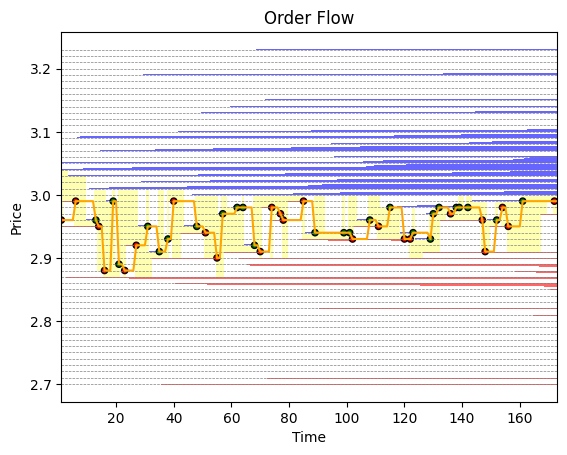

In [24]:
utilities.plot_order_flow(book.book_state_sequence,
                        price_sequence=book.price_sequence,
                        volumes_sequence=book.volumes_sequence,
                        buy_sequence=book.buy_sequence,
                        sell_sequence=book.sell_sequence,
                        ticksize=ticksize
                        )